__NOTE:__ Simple autoencoder motivated to use variational autoencoder which instead of learning latent dimension, it learns latent distribution of the data at hand by assuming data follows gaussian distribution and thus learns only mean and log of variance. 

Ref for why gaussian is used: https://stats.stackexchange.com/questions/402569/why-do-we-use-gaussian-distributions-in-variational-autoencoder

Log of variance is taken since the variance can only be positive thus restrictive to learn on the other hand log of variance can range from $\left(-\infty, \infty\right)$ which does not restrict network to learn values. To learn mean and log of variance, KL Divergence was used since it measures the distance between two distribution along with reconstruction loss. And using the learned mean and log of variance sampling can be done and thus generate required data, this is done via (here z denotes latent dimension):

$$
z_{new} = \mu_{z} + \sigma_{z} * \epsilon
$$

where, $\epsilon \sim \mathcal{N}\left(0, 1\right)$

It is known that $\log{\left(\sigma_{z}^2\right)}$ say $z_{lvar}$ is learned so to get $\sigma_{z}$. We know:

$$
\sigma_{z} = \exp^{\left(\log{\left(\sigma_{z}\right)}\right)}
$$

$$\left(\text{Multiplying and dividing by 2}\right)$$

$$\sigma_{z} = \exp^{\left(\frac{2}{2}\log{\left(\sigma_{z}\right)}\right)}$$

$$\sigma_{z} = \exp^{\left(\frac{2\log{\left(\sigma_{z}\right)}}{2}\right)}$$

$$\sigma_{z} = \exp^{\left(\frac{\log{\left(\sigma_{z}^2\right)}}{2}\right)}$$

$$\sigma_{z} = \exp^{\left(0.5z_{lvar}\right)}$$

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helper Functions

In [2]:
def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

def visualization(dataloader, model, title, clear = True):
    model.eval()
    sigmoid = nn.Sigmoid()
    num_examples = {i:10 for i in range(10)}
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    fig_2, axes_2 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    embed = []
    labels = []
    i = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total = len(dataloader), leave = False)
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            imgs_inp = imgs.view(-1, 1, 28, 28)
            z_mean, z_log_var, embeddings, reconstructed = model(imgs_inp)
            out = sigmoid(reconstructed)
            out = out.view(len(out), 1, 28, 28)
            embeddings = embeddings.view(len(out), -1)
            embed.extend(embeddings.cpu().detach().numpy().tolist())
            labels.extend(lbls.cpu().detach().numpy().tolist())
            for n in num_examples.keys():
                if num_examples[n] <= 0:
                    continue
                idxs = torch.where(lbls == n)[0][:num_examples[n]]
                num_examples[n] -= len(idxs)
                for idx in idxs:
                    idx = idx.item()
                    img = imgs[idx].detach().cpu().numpy()[0]
                    gen = out[idx].detach().cpu().numpy()[0]
                    axes_1[i//10, i%10].imshow(img, cmap = 'gray')
                    axes_1[i//10, i%10].axis('off')
                    axes_2[i//10, i%10].imshow(gen, cmap = 'gray')
                    axes_2[i//10, i%10].axis('off')
                    i+=1

    fig_3, axes = plt.subplots()
    embed = np.array(embed)
    labels = np.array(labels)
    color = plt.get_cmap('Spectral', 10)
    scatter_plot = axes.scatter(embed[:,0], embed[:,1], c = labels, cmap = color, alpha = 0.5, s = 2)
    plt.colorbar(scatter_plot, drawedges = True, ax = axes)
    wandb.log({f"{title}_original": fig_1, f"{title}_regenerated":fig_2, f"{title}_visualization": wandb.Image(fig_3)})
    if clear:
        fig_1.clear()
        plt.close(fig_1)
        fig_2.clear()
        plt.close(fig_2)
        fig_3.clear()
        plt.close(fig_3)

def KL_divergence(latent_mean, latent_log_var):
    example_divergence = torch.sum(-0.5*(1 + latent_log_var - torch.square(latent_mean) - torch.exp(latent_log_var)), dim = -1)
    batch_divergence = torch.mean(example_divergence)
    return batch_divergence

KL Divergence Derivation (univariate gaussian):

Given: 
$$P \sim \mathcal{N}\left(\mu, \sigma \right)$$
$$Q \sim \mathcal{N}\left(0, 1 \right)$$

$$D_{KL} \left(p ||q\right) = \int^{\infty}_{-\infty} \left(p(x)\log{\frac{p(x)}{q(x)}}\right) dx$$

$$= \int^{\infty}_{-\infty} \left(p(x)\log{\frac{\frac{1}{\cancel{\sqrt{2\pi}}\sigma}\exp^{\left(-\frac{\left(x - \mu\right)^2}{2\sigma^2}\right)}}{\frac{1}{\cancel{\sqrt{2\pi}}}\exp^{\left(-\frac{\left(x\right)^2}{2}\right)}}}\right) dx$$

$$= \int^{\infty}_{-\infty} \left(p(x)\log{\frac{\frac{1}{\sigma}\exp^{\left(-\frac{\left(x - \mu\right)^2}{2\sigma^2}\right)}}{\exp^{\left(-\frac{\left(x\right)^2}{2}\right)}}}\right) dx$$

$$= \int^{\infty}_{-\infty} \left(p(x)\log\left(\frac{1}{\sigma}\exp^{\left(-\frac{\left(x - \mu\right)^2}{2\sigma^2}\right)}\right)\right) dx- \int^{\infty}_{-\infty} \left(p(x)\log\left(\exp^{\left(-\frac{\left(x\right)^2}{2}\right)}\right)\right) dx$$

$$= \int^{\infty}_{-\infty} \left(p(x)\log\left(\frac{1}{\sigma}\exp^{\left(-\frac{\left(x - \mu\right)^2}{2\sigma^2}\right)}\right)\right)dx- \int^{\infty}_{-\infty} \left(p(x)\left(-\frac{\left(x\right)^2}{2}\right)\right) dx$$

$$= \int^{\infty}_{-\infty} \left(p(x) \log\left(\frac{1}{\sigma}\right)\right)dx + \int^{\infty}_{-\infty} \left(p(x) \log\left(\exp^{\left(-\frac{\left(x^2 + \mu^2 - 2x\mu\right)}{2\sigma^2}\right)}\right) \right)dx + \frac{1}{2}\int^{\infty}_{-\infty} \left(x^2p(x)\right) dx$$

*******************
Sidenote:
$$\mathbb{E}\left[x\right] = \int^{\infty}_{-\infty} (x.p(x))dx = \mu$$
$$\mathbb{E}\left[x^2\right] = \int^{\infty}_{-\infty} (x^2p(x))dx $$
$$\text{Now we know that: } \mathbb{E}\left[(x-\mu)^2\right] = \sigma^2 (variance) = \mathbb{E}\left[x^2\right] - \left(\mathbb{E}\left[x\right]\right)^2 $$
$$= \mathbb{E}\left[x^2\right] = \sigma^2 + \mu^2$$

*******************

$$= \log\left(\frac{1}{\sigma}\right)\int^{\infty}_{-\infty} \left(p(x)\right)dx + \int^{\infty}_{-\infty} \left(p(x) \left(-\frac{\left(x^2 + \mu^2 - 2x\mu\right)}{2\sigma^2}\right) \right)dx + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

Since p(x) is a pdf, summing over entire x is 1

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2\sigma^2}\int^{\infty}_{-\infty}p(x) \left(x^2 + \mu^2 - 2x\mu\right)dx + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2\sigma^2}\left(\int^{\infty}_{-\infty}p(x)x^2dx + \mu^2\int^{\infty}_{-\infty}p(x)dx - 2\mu\int^{\infty}_{-\infty}p(x)xdx\right) + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2\sigma^2}\left(\sigma^2 + \mu^2 + \mu^2 - 2\mu^2\right) + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2\sigma^2}\left(\sigma^2 + \cancel{\mu^2} + \cancel{\mu^2} + \cancel{2\mu^2}\right) - \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2\cancel{\sigma^2}}\left(\cancel{\sigma^2}\right) + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \log\left(\frac{1}{\sigma}\right) - \frac{1}{2} + \frac{1}{2} \left(\sigma^2 + \mu^2\right) $$

$$= \frac{1}{2}\left(-2\log(\sigma) - 1 + \sigma^2 + \mu^2 \right) $$

$$= -\frac{1}{2}\left(2\log(\sigma) + 1 - \sigma^2 - \mu^2 \right) $$

$$= -\frac{1}{2}\left(\log(\sigma^2) + 1 - \sigma^2 - \mu^2 \right) $$

And the above derived is the final formula for calculating KL divergence loss

__NOTE:__ Through KL divergence we tries to keep our latent distribution to be standard normal variate and thus enables us to choose a latent vector for generation of data. Other distribution such as bernoulli, gamma, uniform, etc. can be tried

# Hyperparameters

In [3]:
batch_size = 64
input_vector_channel = 1
# Setting experiment
wandb.init(dir = 'logs/', project='GAN Projects', name="CNN based VAE")
num_filters = [32, 64, 128]
latent_dim = 2
filter_size = 3
strides = [2, 2, 2]
learning_rate = 1e-03
num_epochs = 25
reconstruct_weight = 500
criterion = nn.BCEWithLogitsLoss()
save_path = './saved_models/vae_cnn.pt'

wandb.config = {
    'batch_size': batch_size,
    'num_filters': num_filters,
    'latent_dim': latent_dim,
    'filter_size': filter_size,
    'strides': strides,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'reconstruct_weight': reconstruct_weight,
    'initializer': 'glorot_uniform',
    'loss': 'bce_logits + kl_divergence'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


# Loading and preprocessing data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: 1.0 - x)]) # Invert Color
fmnist_train = datasets.FashionMNIST('data/', train = True, transform=transform, download=True)
fmnist_val = datasets.FashionMNIST('data/', train=False, transform=transform, download=True)
trainloader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
validloader = DataLoader(fmnist_val, batch_size=batch_size, num_workers=8, pin_memory=True)

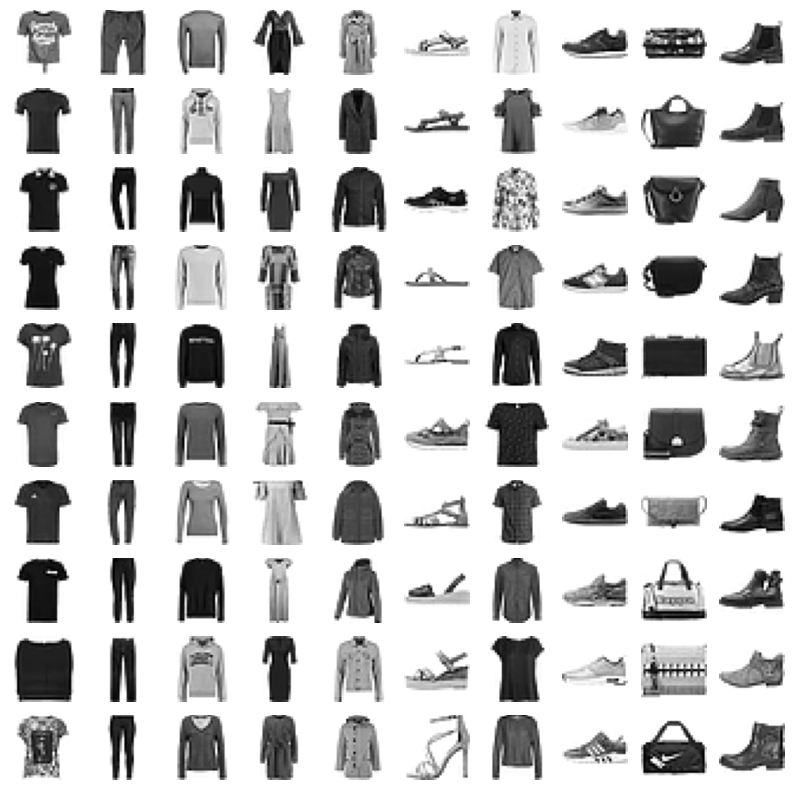

In [5]:
# Visualizing Data
train_images, train_labels = 1.0 - fmnist_train.data, fmnist_train.targets
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

# Autoencoder

In [6]:
# For sampling from given latent_mean and latent_log_var which is used for generation of image
# (This is done for reparamaterization trick introduced in the paper)
class SamplingLayer(nn.Module):
    def __init__(self, latent_dim):
        super(SamplingLayer, self).__init__()
        self.latent_dim = latent_dim

    def forward(self, latent_mean, latent_log_var):
        batch_size = latent_mean.shape[0]
        eps = torch.randn((batch_size, self.latent_dim), device = latent_mean.device)
        return latent_mean + torch.exp(0.5*latent_log_var)*eps

class CNNAutoEncoder(nn.Module):
    def __init__(self, input_vector_channel, num_filters, latent_dim, strides):
        super(CNNAutoEncoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector_channel[0]
        all_units = input_vector_channel + num_filters

        # Encoder
        for i in range(len(all_units) - 1):
            temp = [nn.Conv2d(all_units[i], all_units[i+1], 3, strides[i], padding=1),
                    nn.ReLU(inplace = True)]
            enc_list.extend(temp)

        # Calculated from hand or can run torchsummary once to check dimensions
        self.shape_before_flatten = np.array([128, 4, 4])
        enc_list.append(nn.Flatten())
        self.encoder = nn.Sequential(*enc_list)

        self.mean_layer = nn.Linear(np.prod(self.shape_before_flatten), latent_dim)
        self.var_layer =  nn.Linear(np.prod(self.shape_before_flatten), latent_dim)
        self.sample_layer = SamplingLayer(latent_dim)
        self.bottleneck = nn.Linear(latent_dim, np.prod(self.shape_before_flatten))

        
        # Decoder
        dec_list.extend([nn.ConvTranspose2d(all_units[-1], all_units[-1], 3, 2, padding=1),
                         nn.ReLU(inplace = True)])
        
        for i in range(len(all_units) - 1, 1, -1):
            temp = [nn.ConvTranspose2d(all_units[i], all_units[i-1], 3, strides[i-1], padding = 1, output_padding=1),
                    nn.ReLU(inplace = True)]
            dec_list.extend(temp)
        dec_list.extend([nn.ConvTranspose2d(all_units[i-1], all_units[i-2], 3, 1, padding = 1)])
        self.decoder = nn.Sequential(*dec_list)

        # Initialize weights
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        self.bottleneck.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.encoder(x)
        latent_mean = self.mean_layer(out)
        latent_log_var = self.var_layer(out)
        latent_embed = self.sample_layer(latent_mean, latent_log_var)
        out = self.bottleneck(latent_embed)
        out = out.view(-1, *self.shape_before_flatten)
        out = self.decoder(out)
        return latent_mean, latent_log_var, latent_embed, out

In [7]:
cnn_autoencoder = CNNAutoEncoder([input_vector_channel], num_filters, latent_dim, strides)
summary(cnn_autoencoder, (1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048]                --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 64, 7, 7]            18,496
|    └─ReLU: 2-4                         [-1, 64, 7, 7]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           73,856
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
|    └─Flatten: 2-7                      [-1, 2048]                --
├─Linear: 1-2                            [-1, 2]                   4,098
├─Linear: 1-3                            [-1, 2]                   4,098
├─SamplingLayer: 1-4                     [-1, 2]                   --
├─Linear: 1-5                            [-1, 2048]                6,144
├─Sequential: 1-6                        [-1, 1, 28, 28]           

In [8]:
visualization(trainloader, cnn_autoencoder, "Pre_Train", clear = True)
visualization(validloader, cnn_autoencoder, "Pre_valid", clear = True);

# Training Autoencoder



In [9]:
def train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight = 500, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    imgs = imgs.view(-1, 1, 28, 28)
    with torch.cuda.amp.autocast():
        z_mean, z_log_var, embed, out = model(imgs)
        batch_loss = criterion(out, imgs)*reconst_weight + KL_divergence(z_mean, z_log_var)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          reconst_weight = 500, save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoint
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, reconst_weight, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'epoch':epoch ,'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        visualization(trainloader, cnn_autoencoder, "Epoch_train")
        visualization(validloader, cnn_autoencoder, "Epoch_valid")
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [10]:
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, cnn_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, reconst_weight = reconstruct_weight, save_path=save_path)

#### Saving ####


********** EPOCH  0/25 **********
#################################
Train Loss: 187.331
Valid Loss: 175.208
#################################


#### Saving ####


********** EPOCH  1/25 **********
#################################
Train Loss: 173.083
Valid Loss: 172.763
#################################


#### Saving ####


********** EPOCH  2/25 **********
#################################
Train Loss: 171.374
Valid Loss: 172.031
#################################


#### Saving ####


********** EPOCH  3/25 **********
#################################
Train Loss: 170.451
Valid Loss: 170.956
#################################


********** EPOCH  4/25 **********
#################################
Train Loss: 169.941
Valid Loss: 171.026
#################################


#### Saving ####


********** EPOCH  5/25 **********
#################################
Train Loss: 169.385
Valid Loss: 170.350
#################################


#### Saving ####


********** EPOCH  6/25 **********
#################################
Train Loss: 168.985
Valid Loss: 169.767
#################################


********** EPOCH  7/25 **********
#################################
Train Loss: 168.699
Valid Loss: 169.776
#################################


#### Saving ####


********** EPOCH  8/25 **********
#################################
Train Loss: 168.357
Valid Loss: 169.158
#################################


********** EPOCH  9/25 **********
#################################
Train Loss: 168.063
Valid Loss: 170.002
#################################


********** EPOCH 10/25 **********
#################################
Train Loss: 167.890
Valid Loss: 169.830
#################################


********** EPOCH 11/25 **********
#################################
Train Loss: 167.658
Valid Loss: 169.469
#################################


********** EPOCH 12/25 **********
#################################
Train Loss: 167.536
Valid Loss: 169.413
#################################


#### Saving ####


********** EPOCH 13/25 **********
#################################
Train Loss: 167.312
Valid Loss: 168.674
#################################


#### Saving ####


********** EPOCH 14/25 **********
#################################
Train Loss: 167.176
Valid Loss: 168.498
#################################


********** EPOCH 15/25 **********
#################################
Train Loss: 166.982
Valid Loss: 168.513
#################################


********** EPOCH 16/25 **********
#################################
Train Loss: 166.884
Valid Loss: 168.720
#################################


#### Saving ####


********** EPOCH 17/25 **********
#################################
Train Loss: 166.770
Valid Loss: 168.199
#################################


********** EPOCH 18/25 **********
#################################
Train Loss: 166.638
Valid Loss: 168.237
#################################


#### Saving ####


********** EPOCH 19/25 **********
#################################
Train Loss: 166.416
Valid Loss: 168.115
#################################


********** EPOCH 20/25 **********
#################################
Train Loss: 166.363
Valid Loss: 168.221
#################################


********** EPOCH 21/25 **********
#################################
Train Loss: 166.310
Valid Loss: 168.267
#################################


#### Saving ####


********** EPOCH 22/25 **********
#################################
Train Loss: 166.162
Valid Loss: 167.880
#################################


#### Saving ####


********** EPOCH 23/25 **********
#################################
Train Loss: 166.099
Valid Loss: 167.875
#################################


********** EPOCH 24/25 **********
#################################
Train Loss: 165.972
Valid Loss: 168.037
#################################


********** EPOCH 25/25 **********
#################################
Train Loss: 165.841
Valid Loss: 167.885
#################################


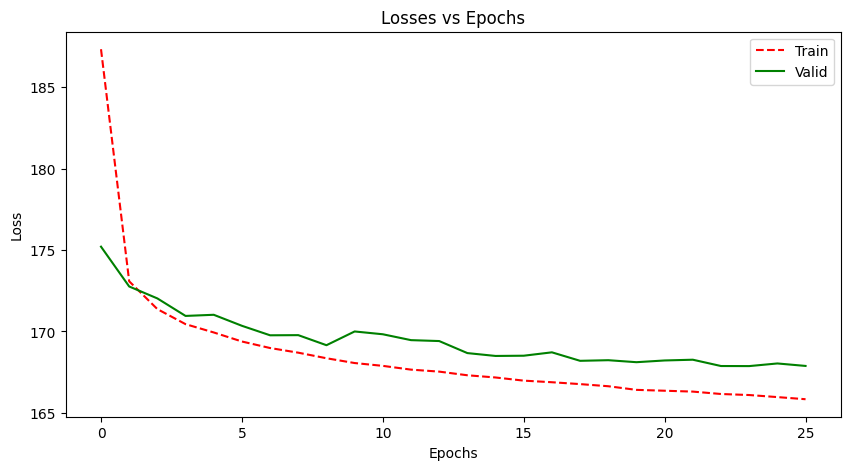

In [11]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show();

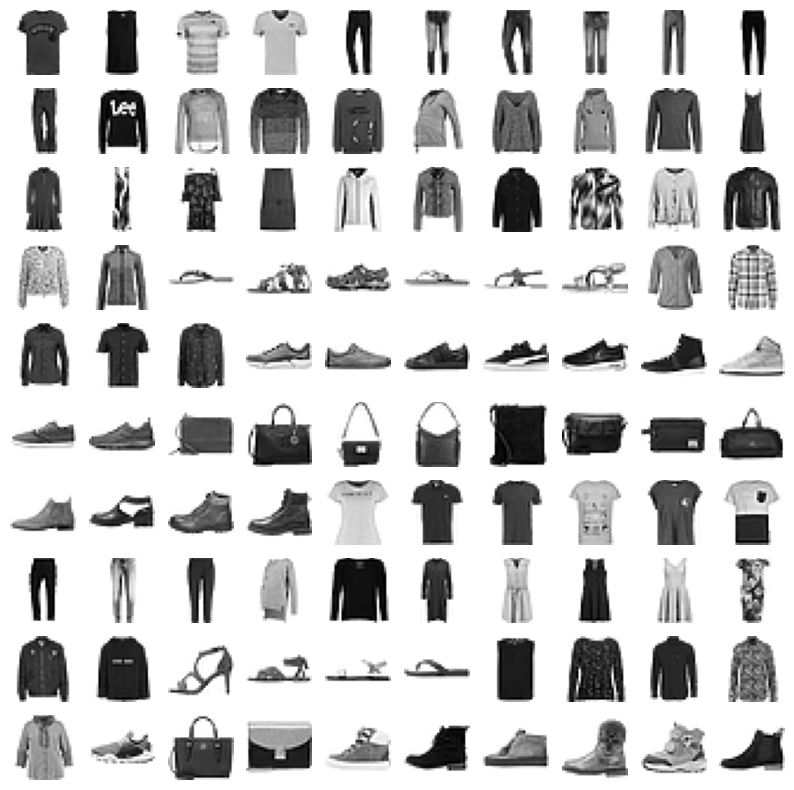

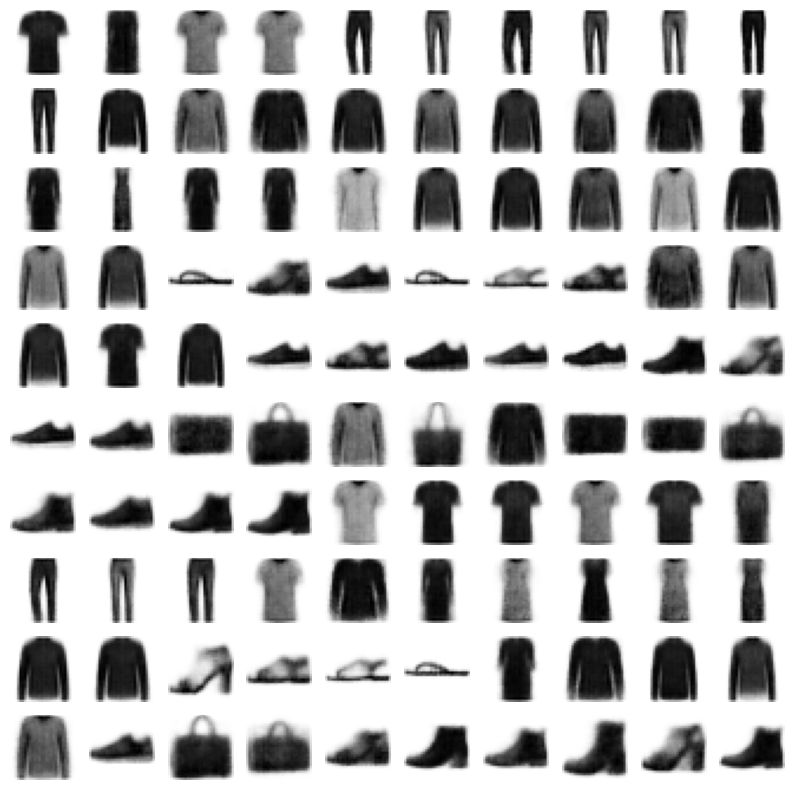

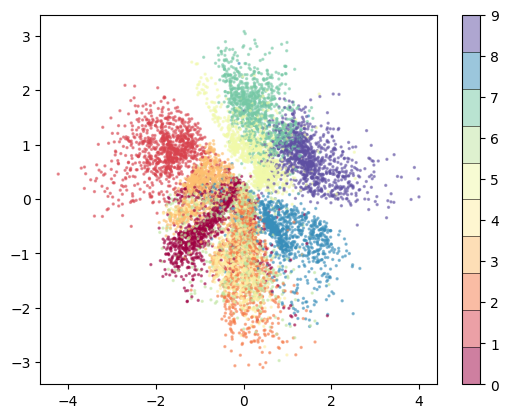

In [12]:
cnn_autoencoder = load_checkpoint(cnn_autoencoder, save_path)
visualization(trainloader, cnn_autoencoder, "Post_train", clear = True)
visualization(validloader, cnn_autoencoder, "Post_valid", clear = False);

__NOTE:__ In VAE Embeddings seems to be centered around origin and bounded (95% of data lies between 3 std dev of normal distribution) unlike in autoencoder where the latent embedding was not bounded at all.

Also noticed that data is clustered well and there is less empty region on the other in autoencoder there was lot of empty region.

All data classes seems to be clustered properly as well and also seems to be evenly distributed unlike before where some classes occupy big region and some occupy small regions

# Sampling and results 

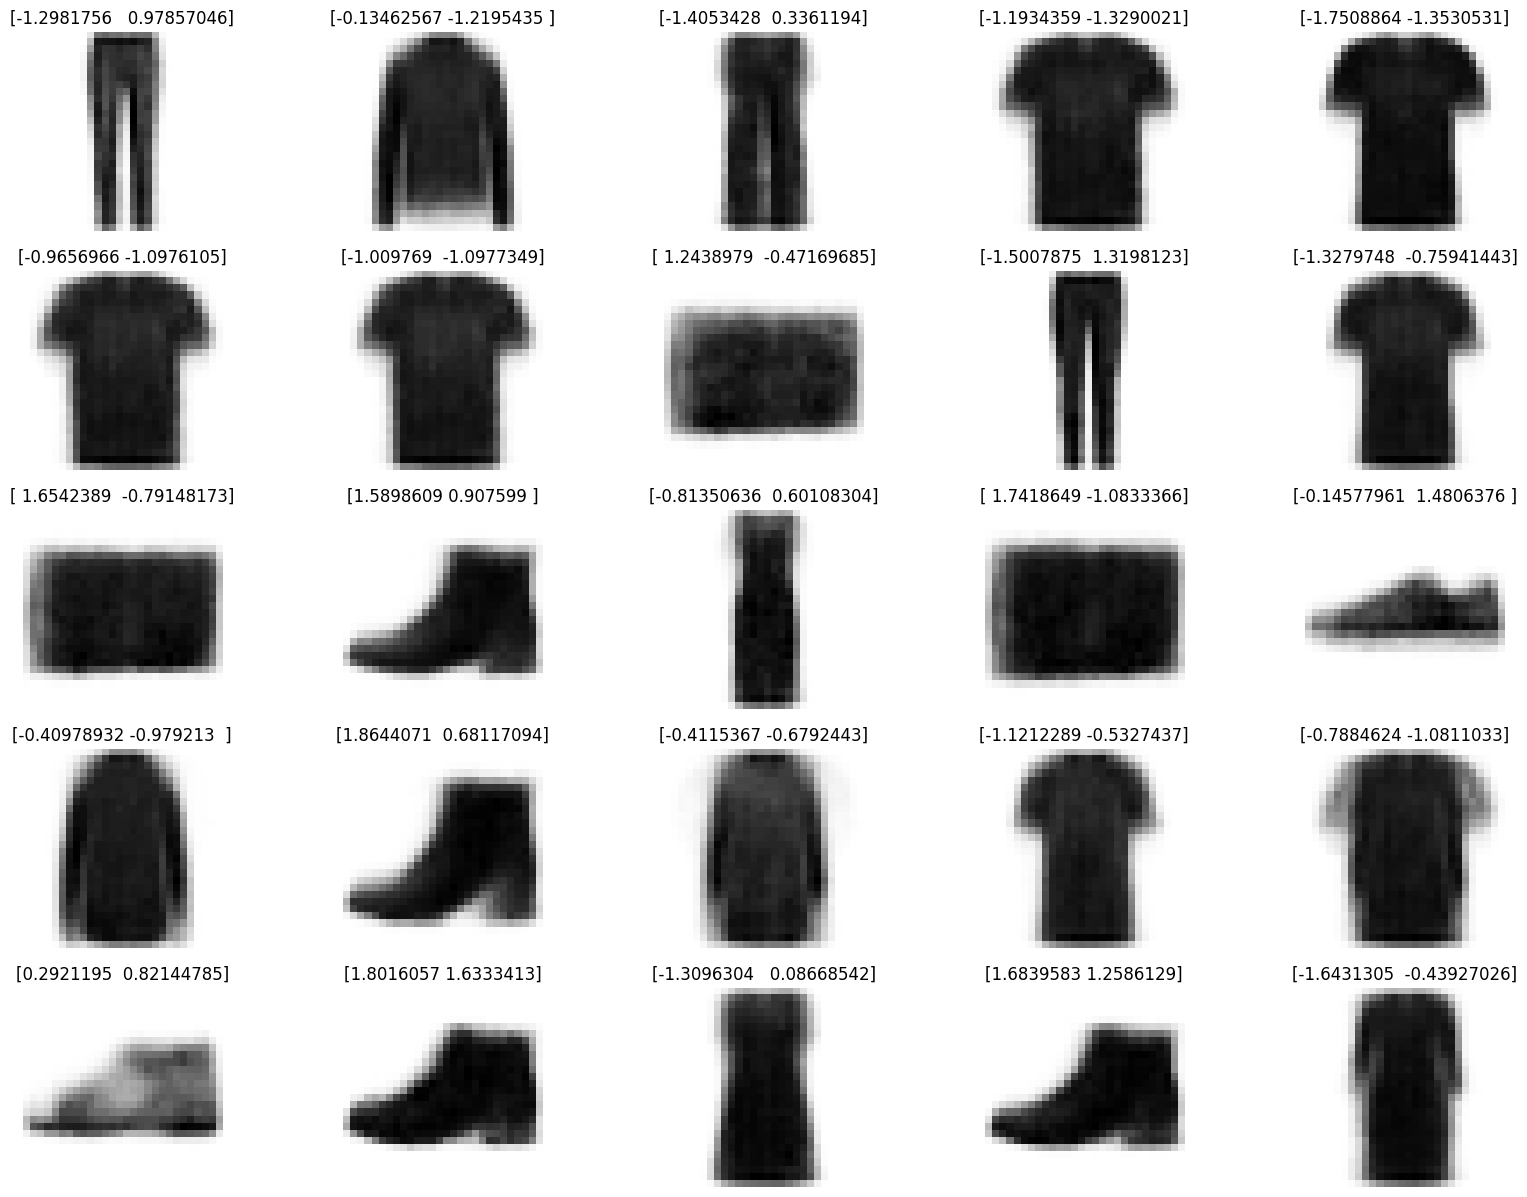

In [13]:
with torch.no_grad():
    cnn_autoencoder.eval()
    min, max = -2, 2

    # Setting for plots
    num_images = 25
    nrows = 5
    ncols = num_images // nrows + (num_images % nrows > 0)

    # Sample and Generation
    samples = (max - min)*torch.rand((num_images, 2)) + min
    samples = samples.to(device)
    sigmoid = nn.Sigmoid()
    out = cnn_autoencoder.bottleneck(samples)
    out = out.view(-1, *[128, 4, 4])
    out_images = cnn_autoencoder.decoder(out)
    out_images = sigmoid(out_images)
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        img = out_images[i][0]
        img = img.detach().cpu().numpy()
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap = 'gray')
        plt.title(f'{samples[i].detach().cpu().numpy()}')
        plt.axis('off')

__NOTE:__ Data generated from latent dimension only seems to be of very high quality and compared to autoencoder very few images, that doesn't make sense, are generated 

# Sampling from a specific region

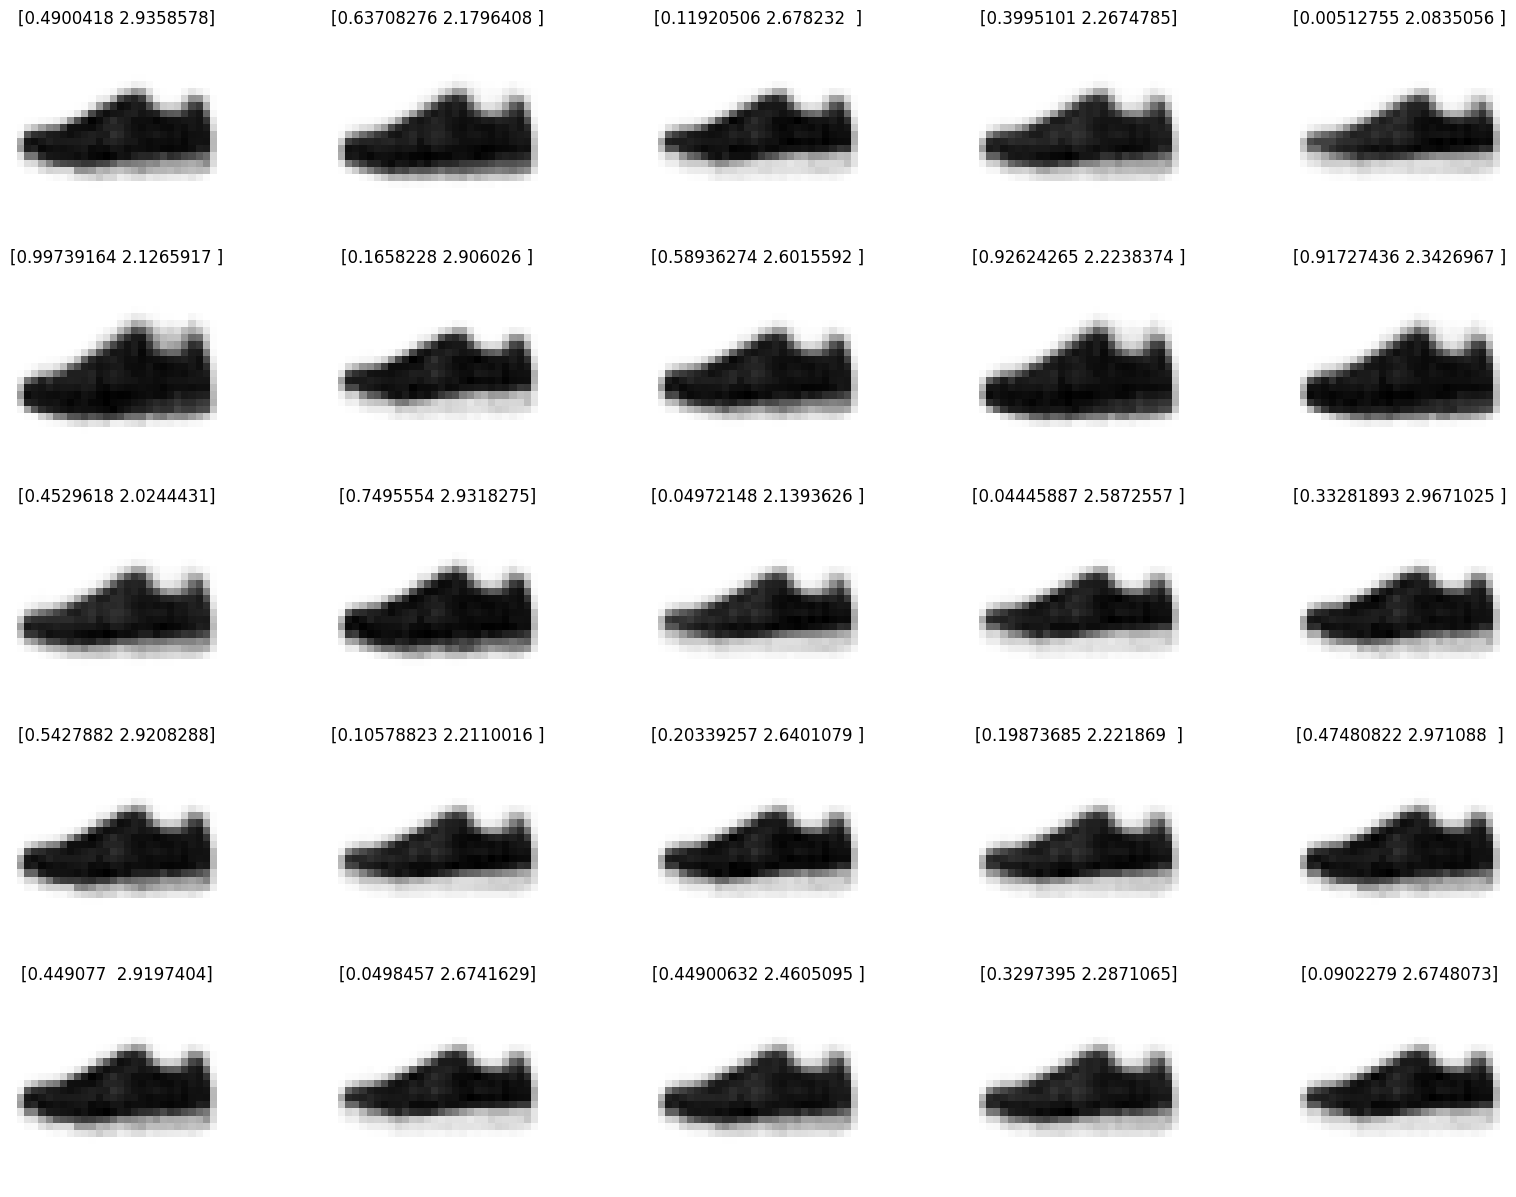

In [14]:
with torch.no_grad():
    cnn_autoencoder.eval()

    # Setting min and max along dimensions to get images of a particular class
    min_1, max_1 = 0, 1
    min_2, max_2 = 2, 3

    # Setting for plots
    num_images = 25
    nrows = 5
    ncols = num_images // nrows + (num_images % nrows > 0)

    # Sample and Generation
    samples = torch.rand((num_images, 2))
    samples[:, 0] = (max_1 - min_1)*samples[:, 0] + min_1
    samples[:, 1] = (max_2 - min_2)*samples[:, 1] + min_2

    samples = samples.to(device)
    sigmoid = nn.Sigmoid()
    out = cnn_autoencoder.bottleneck(samples)
    out = out.view(-1, *[128, 4, 4])
    out_images = cnn_autoencoder.decoder(out)
    out_images = sigmoid(out_images)
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        img = out_images[i][0] # Get first channel
        img = img.detach().cpu().numpy()
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap = 'gray')
        plt.title(f'{samples[i].detach().cpu().numpy()}')
        plt.axis('off')